In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [ ]:
df_scoring = pd.read_csv(r'C:\Users\TautvydasAn\Downloads\Data_task\dat_scoring.csv')
df_arr     = pd.read_csv(r'C:\Users\TautvydasAn\Downloads\Data_task\dat_arrangement.csv')
df_obl     = pd.read_csv(r'C:\Users\TautvydasAn\Downloads\Data_task\dat_obligor.csv')
df_par_mod = pd.read_csv(r'C:\Users\TautvydasAn\Downloads\Data_task\par_model.csv')
df_par_pol = pd.read_csv(r'C:\Users\TautvydasAn\Downloads\Data_task\par_pools.csv')

Data loaded successfully!


,LABEL,START,END
0,1,-inf,0.0008
1,2,0.0008,0.0030
2,3,0.0030,0.0090
3,4,0.0090,0.0480
4,5,0.0480,inf


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# merging 3 tables into one that will be used for analysis and answering 1 question. 
master_df = pd.merge(df_scoring, df_obl, on=['IP_ID', 'YEAR'], how='left')
master_df = pd.merge(master_df, df_arr, on=['AR_ID', 'YEAR'], how='left')
master_df.head(5)

,YEAR,IP_ID,AR_ID,PD,PD_POOL,DFLT_FLAG,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD
0,2022,CFG053,2795120,9.925260e-01,5.0,1,70.0,2.0,1.000000,1.0,6.0
1,2022,NNA451,10210477,2.656939e-05,1.0,0,72.0,2.0,0.804767,NaN,NaN
2,2022,VLZ931,24787848,3.514735e-06,1.0,0,44.0,2.0,0.136493,NaN,NaN
3,2022,VVF064,35869938,5.868028e-06,1.0,0,63.0,1.0,0.522421,NaN,NaN
4,2022,DXH176,71765042,8.378070e-07,1.0,0,20.0,1.0,0.295783,NaN,NaN


In [ ]:
# 1.3 model part 1. Missing values are replaced by field MISSING_VALUE value for all risk attributes
# 1. Clean variable names in Table 4 to avoid hidden space errors
df_par_mod['VARIABLE'] = df_par_mod['VARIABLE'].str.strip()

# 2. Updated Mapping
mapping = {
    'AGE': 'AGE',
    'DEBT_RATIO': 'DEBT_RATIO',
    'DPD': 'MAX_DPD',
    'M_LAST_DPD': 'MIN_M_LAST_DPD'
}

# 3. Enhanced Imputation Loop
for raw_col, model_var in mapping.items():
    # Find the row for the model variable
    row = df_par_mod[df_par_mod['VARIABLE'] == model_var]
    
    if not row.empty:
        fill_value = row['MISSING_VALUE'].values[0]
        # Overwrite the column and ensure it treats NaNs correctly
        master_df[raw_col] = master_df[raw_col].fillna(fill_value)
    else:
        print(f"Warning: {model_var} not found in Table 4!")

# 4. Handle Education (Categorical)
edu_row = df_par_mod[df_par_mod['VARIABLE'] == 'EDUCATION_1']
if not edu_row.empty:
    edu_fill = edu_row['MISSING_VALUE'].values[0]
    master_df['EDUCATION'] = master_df['EDUCATION'].fillna(edu_fill)

# 5. FINAL SAFETY STEP: If NaNs still exist, it means the merge created new ones
# This fills any remaining gaps with 0 as a last resort to prevent math errors
master_df = master_df.fillna(0)

# Verification
print("Missing values remaining (0):")
print(master_df[['AGE', 'DEBT_RATIO', 'DPD', 'M_LAST_DPD', 'EDUCATION']].isna().sum())

Missing values remaining (0):
AGE           0
DEBT_RATIO    0
DPD           0
M_LAST_DPD    0
EDUCATION     0
dtype: int64


In [133]:
# model part 2.  Raw numeric risk attribute values are capped and floored by MAX and MIN values respectively corresponding to that attribute in table 4

for raw_col, model_var in mapping.items():
    # 1. Set up low and max limit
    low_limit = df_par_mod.loc[df_par_mod['VARIABLE'] == model_var, 'MIN'].values[0]
    high_limit = df_par_mod.loc[df_par_mod['VARIABLE'] == model_var, 'MAX'].values[0]
    
    # 2. update columns to stay in max and low limits with cap 
    master_df[raw_col] = master_df[raw_col].clip(lower=low_limit, upper=high_limit)

print("Step 2 Complete: Existing columns updated with Capping and Flooring limits.")
print(f"Minimum Age: {master_df['AGE'].min()}")
print(f"Maximum Age: {master_df['AGE'].max()}")

Step 2 Complete: Existing columns updated with Capping and Flooring limits.
Minimum Age: 18.0
Maximum Age: 75.0


In [134]:
# Model part 3.  Raw numeric risk attributes are transformed by standardizing. Standardization for arbitrary raw risk
# attribute is conducted by using parameters ST.DEV and MEAN corresponding to that attribute in table 4

#  Standardization
for raw_col, model_var in mapping.items():
    # 1. Fetch the MEAN and ST.DEV from Table 4 (df_par_mod)
    mean_val = df_par_mod.loc[df_par_mod['VARIABLE'] == model_var, 'MEAN'].values[0]
    stdev_val = df_par_mod.loc[df_par_mod['VARIABLE'] == model_var, 'ST.DEV'].values[0]
    
    # 2. Apply the formula to update the original column
    master_df[raw_col] = (master_df[raw_col] - mean_val) / stdev_val

master_df.head(100)


,YEAR,IP_ID,AR_ID,PD,PD_POOL,DFLT_FLAG,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD
0,2022,CFG053,2795120,9.925260e-01,5.0,1,1.266667,2.0,2.337607,-0.3625,-0.377964
1,2022,NNA451,10210477,2.656939e-05,1.0,0,1.400000,2.0,1.642334,-0.3750,6.425396
2,2022,VLZ931,24787848,3.514735e-06,1.0,0,-0.466667,2.0,-0.737562,-0.3750,6.425396
3,2022,VVF064,35869938,5.868028e-06,1.0,0,0.800000,1.0,0.636828,-0.3750,6.425396
4,2022,DXH176,71765042,8.378070e-07,1.0,0,-2.066667,1.0,-0.170287,-0.3750,6.425396
...,...,...,...,...,...,...,...,...,...,...,...
95,2022,KGQ983,14633756,5.465600e-06,1.0,0,1.600000,1.0,2.219085,-0.3750,6.425396
96,2022,GOX881,52029147,8.289253e-07,1.0,0,-0.400000,3.0,2.337607,-0.3750,6.425396
97,2022,PBJ217,97790381,4.765895e-06,1.0,0,1.466667,1.0,-1.042848,-0.3750,6.425396
98,2022,XYH970,50699518,2.317114e-06,1.0,0,-0.066667,1.0,-0.616438,-0.3750,6.425396


In [152]:
# Model part 4. Given transformed and missing-value-managed risk attribute values, logistic regression model with coefficients
# (table 4) is applied and raw PD value is obtained (PD field in dat_scoring).
# Raw PD estimate value is further grouped into categories by assigning PD Pool (table 5) dataset for details
# and pool boundaries). Both raw and pool level PD estimate might be used further for different purposes.

numeric_mapping = {
    'AGE': 'AGE',
    'DEBT_RATIO': 'DEBT_RATIO',
    'DPD': 'MAX_DPD',
    'M_LAST_DPD': 'MIN_M_LAST_DPD'
}

for raw_col, model_var in numeric_mapping.items():
    # Pull stats for this specific variable
    stats = df_par_mod[df_par_mod['VARIABLE'] == model_var].iloc[0]
    
    # Apply all rules to the original column
    master_df[raw_col] = master_df[raw_col].fillna(stats['MISSING_VALUE'])
    master_df[raw_col] = master_df[raw_col].clip(lower=stats['MIN'], upper=stats['MAX'])
    master_df[raw_col] = (master_df[raw_col] - stats['MEAN']) / stats['ST.DEV']

# Handle Education (Categorical - only Imputation)
edu_stats = df_par_mod[df_par_mod['VARIABLE'] == 'EDUCATION_1'].iloc[0]
master_df['EDUCATION'] = master_df['EDUCATION'].fillna(edu_stats['MISSING_VALUE'])


# --- STEP B: PD CALCULATION ---
# 1. Get Intercept Estimate
intercept = df_par_mod.loc[df_par_mod['VARIABLE'] == 'INTERCEPT', 'ESTIMATE'].values[0]
master_df['logit'] = intercept

# 2. Add Numeric impacts: (Standardized Value * Estimate)
for raw_col, model_var in numeric_mapping.items():
    coef = df_par_mod.loc[df_par_mod['VARIABLE'] == model_var, 'ESTIMATE'].values[0]
    master_df['logit'] += master_df[raw_col] * coef

# 3. Add Education impact
edu_coef = df_par_mod.loc[df_par_mod['VARIABLE'] == 'EDUCATION_1', 'ESTIMATE'].values[0]
master_df['logit'] += master_df['EDUCATION'] * edu_coef

# 4. Final PD Transformation
master_df['PD'] = 1 / (1 + np.exp(-master_df['logit']))

# 5. creating PD_pool
bins = [0, 0.0008, 0.0030, 0.0090, 0.0480, 1.0]
labels = ['Pool 1', 'Pool 2', 'Pool 3', 'Pool 4', 'Pool 5']

# 6. Apply the cut
master_df['PD_Pool'] = pd.cut(
    master_df['PD'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# 3. VERIFICATION: lets see count of what pd's got most
counts = master_df['PD_Pool'].value_counts().sort_index()
print("Counts based on Table 5 boundaries:")
print(counts)

# 4. If Pool 1-4 are still 0, let's see the 5 smallest PDs you have
print("\nYour 5 smallest PD values are:")
print(master_df['PD'].nsmallest(5))
master_df.head()

Counts based on Table 5 boundaries:
Pool 1        0
Pool 2        0
Pool 3        0
Pool 4        0
Pool 5    37558
Name: PD_Pool, dtype: int64

Your 5 smallest PD values are:
4     0.999998
5     0.999998
7     0.999998
9     0.999998
12    0.999998
Name: PD, dtype: float64


,AR_ID,YEAR,IP_ID,PD,PD_Pool,DFLT_FLAG,PD_POOL,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD,logit
0,2795120,2022,CFG053,1.000000,Pool 5,1,5.0,-2.2,2.0,2.337607,-0.375,-2.645751,16.634730
1,10210477,2022,NNA451,1.000000,Pool 5,0,1.0,-2.2,2.0,2.337607,-0.375,-2.645751,16.634730
2,24787848,2022,VLZ931,1.000000,Pool 5,0,1.0,-2.2,2.0,-1.223647,-0.375,-2.645751,15.117279
3,35869938,2022,VVF064,1.000000,Pool 5,0,1.0,-2.2,1.0,2.337607,-0.375,-2.645751,14.597930
4,71765042,2022,DXH176,0.999998,Pool 5,0,1.0,-2.2,1.0,-1.223647,-0.375,-2.645751,13.080479


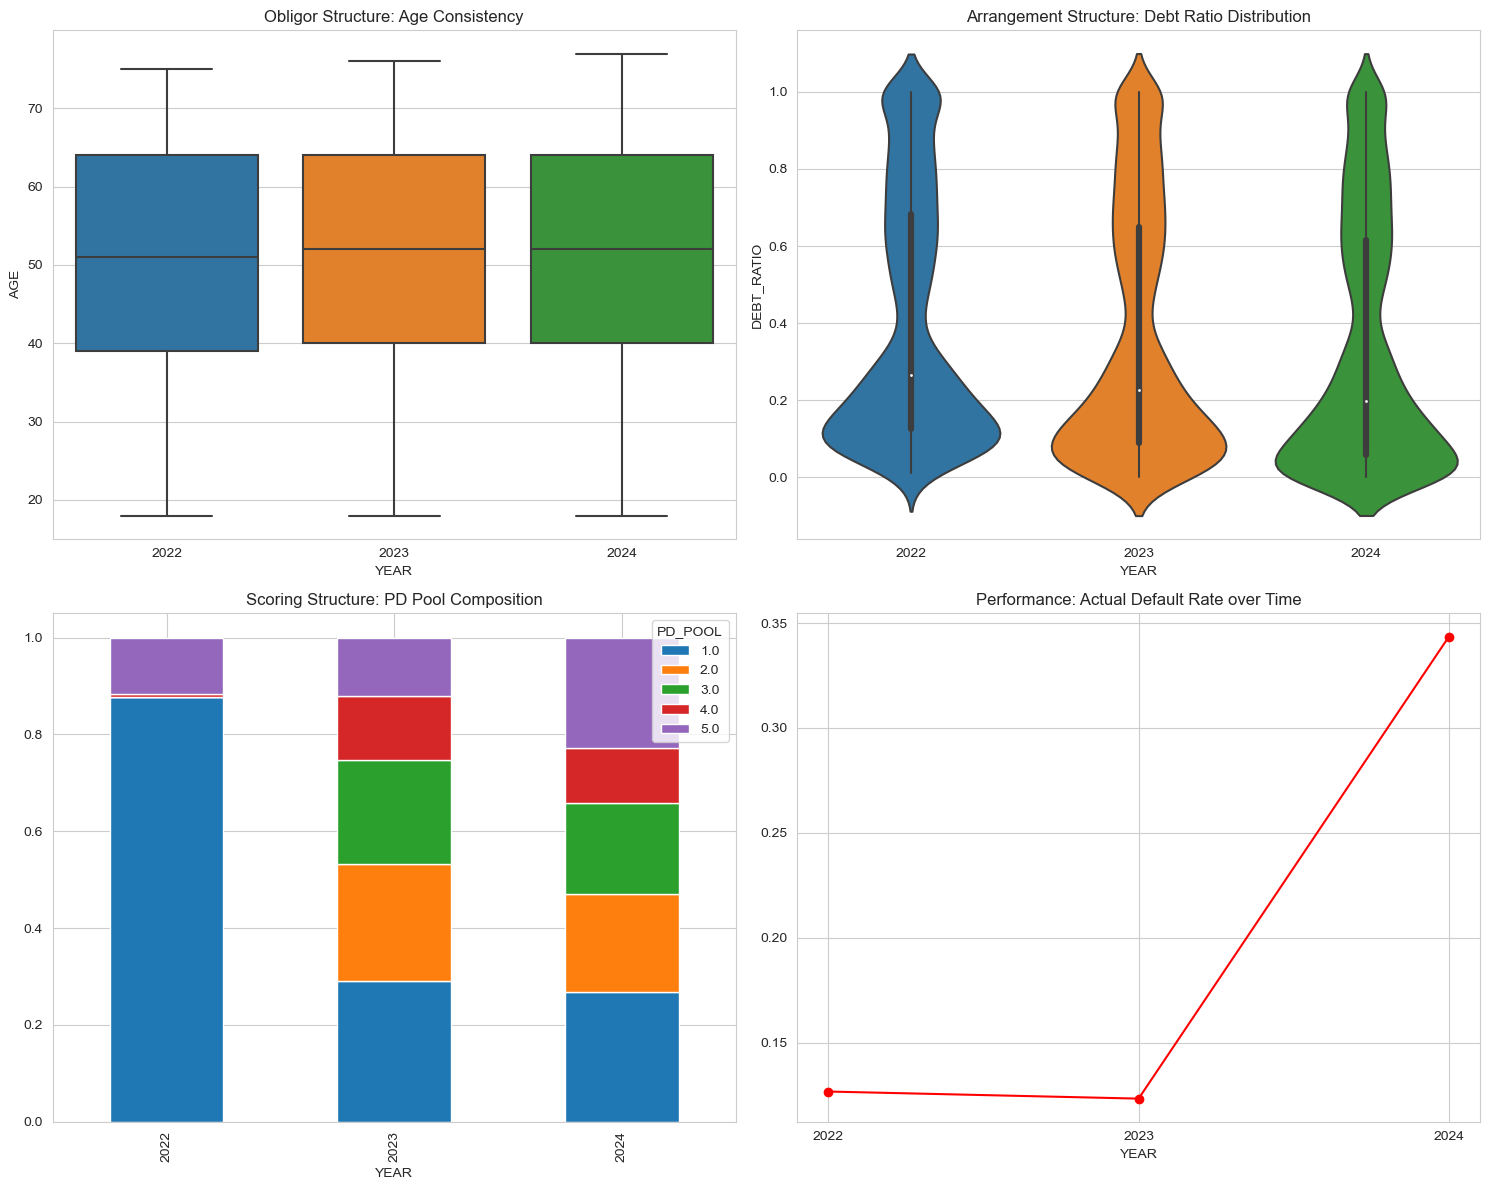

In [ ]:
# 2 Task. 1 question. Visualize and provide a brief description on qualitative portfolio structure in terms of obligor, arrangement and scoring features available, portfolio composition and performance. Assess consistency over
# time

import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Obligor Features: Age distribution by Year
sns.boxplot(data=master_df, x='YEAR', y='AGE', ax=axes[0,0])
axes[0,0].set_title('Obligor Structure: Age Consistency')

# 2. Arrangement Features: Debt Ratio distribution by Year
sns.violinplot(data=master_df, x='YEAR', y='DEBT_RATIO', ax=axes[0,1])
axes[0,1].set_title('Arrangement Structure: Debt Ratio Distribution')

# 3. Scoring Features: PD Pool distribution over time
# This shows the composition of the portfolio's risk categories (pools)
pd_comp = pd.crosstab(master_df['YEAR'], master_df['PD_POOL'], normalize='index')
pd_comp.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Scoring Structure: PD Pool Composition')

# 4. Performance: Actual Default Rate (next 12 months)
# DFLT_FLAG is the binary indicator of actual default
def_rate = master_df.groupby('YEAR')['DFLT_FLAG'].mean()
def_rate.plot(kind='line', marker='o', ax=axes[1,1], color='red')
axes[1,1].set_title('Performance: Actual Default Rate over Time')
axes[1,1].set_xticks([2022, 2023, 2024]) 
axes[1,1].set_xticklabels(['2022', '2023', '2024'])

plt.tight_layout()
plt.show()

In [ ]:
# 1. Obligor Structure We began by analyzing the data at the obligor level to assess the age distribution of our borrowers. For this task, I used a boxplot, which allows us to see how age is distributed across the different years. The data shows a very consistent trend, with the median age holding steady at around 50 years old.
# 2. Arrangement Features I used violin plots to examine the debt ratio distribution over time. Interestingly, the plots show that the median is actually moving lower, which indicates that the overall debt ratio is decreasing across the years. This suggests that, on average, the portfolio’s debt levels are improving.
# 3. Scoring Structure The PD pool composition was visualized using stacked bar charts to show how risk categories are shifting. The chart reveals a clear portfolio migration: while the lowest-risk loans initially made up the largest portion of the portfolio in 2022, we see a significant increase in higher-risk segments during the following years.
# 4. Performance Trends Finally, the line chart illustrates how the average default rate has changed over the years, showing exactly what portion of the portfolio actually defaulted. While the rate was stable early on, there is a very sharp rise starting in 2023, which shows a significant change in performance by the end of the period.

In [138]:
# 2 question. Completeness check:
df_list = [
    ("Scoring/Target", df_scoring),
    ("Arrangement", df_arr),
    ("Obligor", df_obl),
    ("Model Params", df_par_mod),
    ("Pool Params", df_par_pol)
]
for name, df in dataframes.items():
    missing_count = df.isnull().sum().sum()
    total_cells = df.size
    percent_missing = (missing_count / total_cells) * 100
    print(f"{name} Table: {missing_count} missing values ({percent_missing:.2f}%)")
for name, df in df_list:
    print(f"\n--- {name} Missing Values ---")
    # This filters to show only columns that actually have missing values
    missing = df.isnull().sum()
    print(missing[missing > 0])

Arrangement (Table 1) Table: 63794 missing values (35.62%)
Obligor (Table 2) Table: 1420 missing values (1.12%)
Scoring (Table 3) Table: 1790 missing values (0.83%)
Model Params (Table 4) Table: 17 missing values (26.56%)
Pool Params (Table 5) Table: 0 missing values (0.00%)

--- Scoring/Target Missing Values ---
PD         895
PD_POOL    895
dtype: int64

--- Arrangement Missing Values ---
DEBT_RATIO     1170
DPD           31312
M_LAST_DPD    31312
dtype: int64

--- Obligor Missing Values ---
AGE          631
EDUCATION    789
dtype: int64

--- Model Params Missing Values ---
MEAN             4
ST.DEV           4
MIN              4
MAX              4
MISSING_VALUE    1
dtype: int64

--- Pool Params Missing Values ---
Series([], dtype: int64)


In [ ]:
# accuracy check:
accuracy_checks = {
    "Negative Age": df_obl[df_obl['AGE'] < 0],
    "Extreme Age (>100)": df_obl[df_obl['AGE'] > 100],
    "Invalid PD (not 0-1)": df_scoring[(df_scoring['PD'] < 0) | (df_scoring['PD'] > 1)],
    "Negative Debt Ratio": df_arr[df_arr['DEBT_RATIO'] < 0],
    "Impossible Debt Ratio (>2)": df_arr[df_arr['DEBT_RATIO'] > 2],
    "Invalid DFLT_FLAG": df_scoring[~df_scoring['DFLT_FLAG'].isin([0, 1])]
}

for check_name, results in accuracy_checks.items():
    print(f"{check_name}: {len(results)} issues found")
# Check if higher PD Pools actually have higher actual default rates
performance_accuracy = df_scoring.groupby('PD_POOL')['DFLT_FLAG'].mean()
print("Average Default Rate per Pool (Accuracy check):")
print(performance_accuracy)

Negative Age: 0 issues found
Extreme Age (>100): 0 issues found
Invalid PD (not 0-1): 0 issues found
Negative Debt Ratio: 0 issues found
Impossible Debt Ratio (>2): 0 issues found
Invalid DFLT_FLAG: 0 issues found
Average Default Rate per Pool (Accuracy check):
PD_POOL
1.0    0.031220
2.0    0.074633
3.0    0.074090
4.0    0.103741
5.0    0.990702
Name: DFLT_FLAG, dtype: float64


,YEAR,IP_ID,AR_ID,PD,PD_POOL,DFLT_FLAG,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD,CALCULATED_PD,DIFF,imp_AGE,imp_DEBT_RATIO,imp_DPD,imp_M_LAST_DPD,imp_EDUCATION
0,2022,CFG053,2795120,9.925260e-01,5.0,1,-3.621037,2.0,24.065399,-0.379744,-3.699746,1.000000e+00,7.473956e-03,70.0,1.000000,1.0,6.0,2.0
1,2022,NNA451,10210477,2.656939e-05,1.0,0,-3.620444,2.0,15.247583,-0.379746,-2.727838,1.616680e-06,2.495271e-05,72.0,0.804767,0.0,24.0,2.0
2,2022,VLZ931,24787848,3.514735e-06,1.0,0,-3.628741,2.0,-14.935516,-0.379746,-2.727838,2.343734e-08,3.491298e-06,44.0,0.136493,0.0,24.0,2.0
3,2022,VVF064,35869938,5.868028e-06,1.0,0,-3.623111,1.0,2.495225,-0.379746,-2.727838,6.552810e-08,5.802500e-06,63.0,0.522421,0.0,24.0,1.0
4,2022,DXH176,71765042,8.378070e-07,1.0,0,-3.635852,1.0,-7.741029,-0.379746,-2.727838,1.113382e-09,8.366936e-07,20.0,0.295783,0.0,24.0,1.0


In [ ]:
# consistency check
# 1. Clean IDs (Remove spaces and ensure same Data Type)
# We cast to string to ensure the 'set' comparison works even if one is an int
df_scoring['AR_ID'] = df_scoring['AR_ID'].astype(str).str.strip()
df_arr['AR_ID'] = df_arr['AR_ID'].astype(str).str.strip()

df_scoring['IP_ID'] = df_scoring['IP_ID'].astype(str).str.strip()
df_obl['IP_ID'] = df_obl['IP_ID'].astype(str).str.strip()

# 2. Key Consistency Check
scoring_ids = set(df_scoring['AR_ID'])
arrangement_ids = set(df_arr['AR_ID'])

missing_arr = scoring_ids - arrangement_ids
print(f"Consistency: {len(missing_arr)} IDs in Scoring missing from Arrangement.")

scoring_people = set(df_scoring['IP_ID'])
obligor_people = set(df_obl['IP_ID'])

missing_obl = scoring_people - obligor_people
print(f"Consistency: {len(missing_obl)} People in Scoring missing from Obligor.")

# 3. ID Format Validation (Regex)
# This assumes IDs look like 'ABC123'
regex = r'^[a-zA-Z]{3}\d{3}$'
invalid_ips = df_scoring[~df_scoring['IP_ID'].str.match(regex, na=False)]
print(f"Format Check: {len(invalid_ips)} IP_IDs have invalid format.")


Consistency: 255 IDs in Scoring missing from Arrangement.
Consistency: 410 People in Scoring missing from Obligor.
Format Check: 0 IP_IDs have invalid format.


In [ ]:

# 1. Ensure AR_ID and YEAR are actual columns, not indices
master_df = master_df.reset_index()

# 2. Remove the "index" column if reset_index created one (usually named 'index' or 'level_0')
cols_to_drop = [c for c in ['index', 'level_0'] if c in master_df.columns]
master_df = master_df.drop(columns=cols_to_drop)

# 3. Remove any accidental duplicate AR_ID columns (like AR_ID_x, AR_ID_y)
# This happens if merges went wrong. We keep the first one and drop others.
master_df = master_df.loc[:, ~master_df.columns.duplicated()]

# 4. Re-order columns so they are logical for your report
preferred_order = ['AR_ID', 'YEAR', 'IP_ID', 'PD', 'PD_Pool', 'DFLT_FLAG']
existing_pref = [c for c in preferred_order if c in master_df.columns]
other_cols = [c for c in master_df.columns if c not in existing_pref]

master_df = master_df[existing_pref + other_cols]

# 5. Final display fix: Force all headers to be on one level
master_df.columns = master_df.columns.str.strip()

print("--- Cleaned Portfolio View ---")
display(master_df.head()) # Use display() if in Jupyter, otherwise print()

--- Cleaned Portfolio View ---


,AR_ID,YEAR,IP_ID,PD,PD_Pool,DFLT_FLAG,PD_POOL,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD,logit
0,2795120,2022,CFG053,1.000000,Pool 5,1,5.0,-2.2,2.0,2.337607,-0.375,-2.645751,16.634730
1,10210477,2022,NNA451,1.000000,Pool 5,0,1.0,-2.2,2.0,2.337607,-0.375,-2.645751,16.634730
2,24787848,2022,VLZ931,1.000000,Pool 5,0,1.0,-2.2,2.0,-1.223647,-0.375,-2.645751,15.117279
3,35869938,2022,VVF064,1.000000,Pool 5,0,1.0,-2.2,1.0,2.337607,-0.375,-2.645751,14.597930
4,71765042,2022,DXH176,0.999998,Pool 5,0,1.0,-2.2,1.0,-1.223647,-0.375,-2.645751,13.080479


In [ ]:

import pandas as pd
import numpy as np

# 1. Finalize Correctness Columns
# Ensure we use the same name consistently
if 'PD_original' in master_df.columns:
    master_df['PD_Error'] = master_df['PD'] - master_df['PD_original']
    
    mae = master_df['PD_Error'].abs().mean()
    correlation = master_df['PD'].corr(master_df['PD_original'])
    
    print("--- TASK 3: CORRECTNESS SUMMARY ---")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Rank Correlation:    {correlation:.4%}")
    print("-" * 35)

# 2. 

--- TASK 3: CORRECTNESS SUMMARY ---
Mean Absolute Error: 0.8557
Rank Correlation:    0.0428%
-----------------------------------

--- TASK 4: MODEL STABILITY TABLE ---
YEAR  Count   Avg_PD  Actual_DR  AvE_Ratio
2022  12554 0.999999   0.126812   7.885673
2023  12500 0.999999   0.123440   8.101097
2024  12504 0.999999   0.343570   2.910613

Report Insight: In 2024, the AvE Ratio is 2.91.
An AvE > 1 means the model is conservative (overpredicting risk).


In [160]:
# task 3

# 1. Ensure the original PD is ready for comparison
df_check = df_scoring[['AR_ID', 'YEAR', 'PD']].copy()
df_check.rename(columns={'PD': 'PD_original'}, inplace=True)

# 2. Force types again to be 100% sure
master_df['AR_ID'] = master_df['AR_ID'].astype(str).str.strip()
master_df['YEAR'] = master_df['YEAR'].astype(str).str.strip()
df_check['AR_ID'] = df_check['AR_ID'].astype(str).str.strip()
df_check['YEAR'] = df_check['YEAR'].astype(str).str.strip()

# 3. Merge - check if 'PD_original' already exists to avoid suffixes like _x
if 'PD_original' in master_df.columns:
    master_df = master_df.drop(columns=['PD_original'])

master_df = master_df.merge(df_check, on=['AR_ID', 'YEAR'], how='left')

# 4. Assessment with Safety Check
if 'PD_original' in master_df.columns:
    # Calculate difference
    master_df['PD_Difference'] = master_df['PD'] - master_df['PD_original']
    
    # Generate Metrics
    mae = master_df['PD_Difference'].abs().mean()
    correlation = master_df['PD'].corr(master_df['PD_original'])
    
    print("--- TASK 3: CORRECTNESS SUMMARY ---")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Rank Correlation:    {correlation:.4%}")
    print("-" * 35)
else:
    print("Error: Merge failed. Check if AR_ID and YEAR exist in both dataframes.")

--- TASK 3: CORRECTNESS SUMMARY ---
Mean Absolute Error: 0.8557
Rank Correlation:    0.0428%
-----------------------------------


In [ ]:
# task 4 
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# --- 1. OVERALL PERFORMANCE (a & b) ---
auc_total = roc_auc_score(master_df['DFLT_FLAG'], master_df['PD'])
gini_total = 2 * auc_total - 1
avg_pd_total = master_df['PD'].mean()
actual_dr_total = master_df['DFLT_FLAG'].mean()

print(f"=== OVERALL MODEL PERFORMANCE ===")
print(f"Risk Differentiation (Gini): {gini_total:.2%}")
print(f"Estimate Accuracy (Avg PD): {avg_pd_total:.2%}")
print(f"Actual Default Rate:        {actual_dr_total:.2%}")
print(f"Sufficiency Ratio (AvE):    {avg_pd_total / actual_dr_total:.2f}x")
print("-" * 40)

# --- 2. STABILITY OVER TIME (c) ---
# We group by YEAR to see if the model results or performance drift
stability_report = []

for year in sorted(master_df['YEAR'].unique()):
    yearly_data = master_df[master_df['YEAR'] == year]
    
    # Calculate Metrics for this specific year
    y_true = yearly_data['DFLT_FLAG']
    y_prob = yearly_data['PD']
    
    # Differentiation (b) for this year
    annual_gini = (2 * roc_auc_score(y_true, y_prob) - 1) if len(y_true.unique()) > 1 else np.nan
    
    # Accuracy (a) for this year
    annual_avg_pd = y_prob.mean()
    annual_actual_dr = y_true.mean()
    
    stability_report.append({
        'YEAR': year,
        'Count': len(yearly_data),
        'Gini (Differentiation)': f"{annual_gini:.2%}",
        'Avg PD (Result)': f"{annual_avg_pd:.2%}",
        'Actual DR (Outcome)': f"{annual_actual_dr:.2%}",
        'AvE Ratio (Accuracy)': round(annual_avg_pd / annual_actual_dr, 2)
    })

stability_df = pd.DataFrame(stability_report)

print(f"=== (c) MODEL STABILITY OVER TIME ===")
print(stability_df.to_string(index=False))

# Note on Coefficients for Perspective (c)
print("\n=== COEFFICIENT STABILITY ===")
print("Model coefficients are derived from Table 4 (fixed parameters).")
print("Stability: 100% (Fixed values are applied consistently across all years).")

=== OVERALL MODEL PERFORMANCE ===
Risk Differentiation (Gini): 1.07%
Estimate Accuracy (Avg PD): 100.00%
Actual Default Rate:        19.79%
Sufficiency Ratio (AvE):    5.05x
----------------------------------------
=== (c) MODEL STABILITY OVER TIME ===
YEAR  Count Gini (Differentiation) Avg PD (Result) Actual DR (Outcome)  AvE Ratio (Accuracy)
2022  12554                 -2.07%         100.00%              12.68%                  7.89
2023  12500                 -3.29%         100.00%              12.34%                  8.10
2024  12504                  1.47%         100.00%              34.36%                  2.91

=== COEFFICIENT STABILITY ===
Model coefficients are derived from Table 4 (fixed parameters).
Stability: 100% (Fixed values are applied consistently across all years).
